# Init

In [1]:
import os, sys

import numpy as np
import matplotlib.pyplot as plt

config = "bruz"
if config == "ur1":
    sys.path.insert(0, "../")
    siepelDir = "C:/Users/pleroy/Documents/CAMILL/SER/WR15_v2"
elif config == "bruz":
    sys.path.insert(0, "/home/pleroy/DEV/DIADEM")
    siepelDir = "/home/pleroy/DATA/CAMILL/WR15_v2"

import toolsdiadem.tools as dia
import toolsdiadem.ser as ser
from toolsdiadem.Probe import Probe
from toolsdiadem.ConfigSer2 import ConfigSer2

In [2]:
#%matplotlib qt5
%load_ext autoreload
%autoreload 2

In [3]:
cmap='jet'
conf = ConfigSer2(os.path.join(siepelDir, "wr15.ini"))
conf.printConfig()
dataShape = (conf.sup.nb_elev, conf.sup.nb_freq)

/home/pleroy/DATA/CAMILL/WR15_v2/wr15.ini
base_path (path to the ini file): /home/pleroy/DATA/CAMILL/WR15_v2
out_path (for the processing outputs): /home/pleroy/DATA/CAMILL/WR15_v2/processing/wr15
gateWidth 500.0
gateCenter 6450.0
centerFreq 62.5
bandWidth 12.4
idxElevation 20
vmin -90.0
vmax -40.0

SUPPORT
nb_elev 41
nb_freq 2001
nb_ssb 3
el0 0.7
az0 -0.44

REFERENCE
nb_elev 41
nb_freq 2001
nb_ssb 3
el0 0.31
az0 -0.44


# Données de la sonde

In [4]:
probe = Probe(os.path.join(conf.base_path, "S11FDC_WR15.s1p"))
probe_v2 = Probe(os.path.join(conf.base_path, "S11_PROBE_WR15_2020_08_19.s1p"))

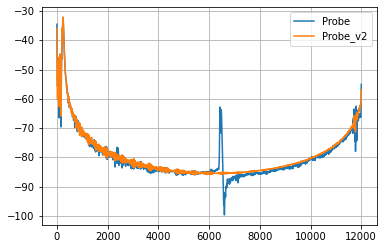

In [5]:
fig, ax = plt.subplots(1,1)
ax.plot(probe.d, ser.dB(np.fft.ifft(probe.S11)), label=f"Probe" )
ax.plot(probe_v2.d, ser.dB(np.fft.ifft(probe_v2.S11)), label=f"Probe_v2" )
ax.legend()
ax.grid()

# Données des plaques

## Référence

In [8]:
dir_ref = f"{conf.base_path}/20200706/026_plaqueRef"
freq_reference, S11_reference = ser.getData_ssb(conf.ref.nb_elev, conf.ref.nb_freq, conf.ref.nb_ssb, dir_ref)
S11_reference_compensated = S11_reference - probe.S11

In [10]:
d = np.linspace(0, 300 / (freq_reference[1]-freq_reference[0]), conf.ref.nb_freq) * 0.5;

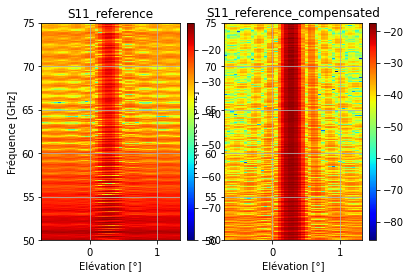

In [13]:
fig, (ax0, ax1) = plt.subplots(1,2)

im = ax0.pcolormesh(conf.ref.elevation, freq_reference, ser.dB(S11_reference).T, cmap=cmap, shading='auto')
title = f"S11_reference"
ax0.set_title(title)
ax0.set_xlabel( "Elévation [°]" )
ax0.set_ylabel( "Fréquence [GHz]" )
dia.addColorBar(  im, ax0, aspect='auto' )

im = ax1.pcolormesh(conf.ref.elevation, freq_reference, ser.dB(S11_reference_compensated).T, cmap=cmap, shading='auto')
title = f"S11_reference_compensated"
ax1.set_title(title)
ax1.set_xlabel( "Elévation [°]" )
ax1.set_ylabel( "Fréquence [GHz]" )
dia.addColorBar(  im, ax1, aspect='auto' )

## Support

In [16]:
data_dir = f"{conf.base_path}/20200701/plaqueSupport"
freq_support, S11_support = ser.getData_ssb(
    conf.sup.nb_elev, conf.sup.nb_freq, conf.sup.nb_ssb, data_dir)
S11_support_compensated = S11_support - probe.S11

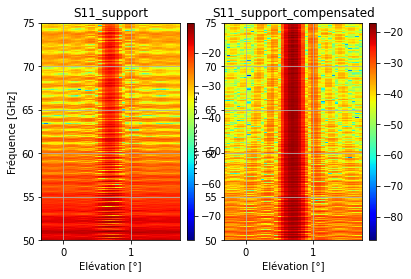

In [21]:
fig, (ax0, ax1) = plt.subplots(1,2)

im = ax0.pcolormesh(conf.sup.elevation, freq_support, ser.dB(S11_support).T, cmap=cmap, shading='auto')
title = f"S11_support"
ax0.set_title(title)
ax0.set_xlabel( "Elévation [°]" )
ax0.set_ylabel( "Fréquence [GHz]" )
dia.addColorBar(  im, ax0, aspect='auto' )

im = ax1.pcolormesh(conf.sup.elevation, freq_support, ser.dB(S11_support_compensated).T, cmap=cmap, shading='auto')
title = f"S11_support_compensated"
ax1.set_title(title)
ax1.set_xlabel( "Elévation [°]" )
ax1.set_ylabel( "Fréquence [GHz]" )
dia.addColorBar(  im, ax1, aspect='auto' )

# Recherche de maximum

In [23]:
idx = np.where(abs(d - conf.gateCenter) < conf.gateWidth)[0]

## Référence

In [25]:
maxVals = np.amax(np.abs(np.fft.ifft(S11_reference, axis=1))[:,idx], axis=1)
maxElev = np.where(maxVals == np.amax(maxVals))
print(f"maxElev = {maxElev}")
iElevRef = maxElev[0][0]
print(f"[b] elevationPlaque at maximum: {conf.ref.elevation[iElevRef]:.2f}")

maxElev = (array([20]),)
[b] elevationPlaque at maximum: 0.31


## Support

In [27]:
maxVals = np.amax(np.abs(np.fft.ifft(S11_support, axis=1))[:,idx], axis=1)
maxElev = np.where(maxVals == np.amax(maxVals))
print(f"maxElev = {maxElev}")
iElevSupportMax = maxElev[0][0]
print(f"[b] elevationSupport at maximum: {conf.sup.elevation[iElevSupportMax]:.2f}")

maxElev = (array([20]),)
[b] elevationSupport at maximum: 0.70


## Plot

In [28]:
ref_max = S11_reference[iElevRef,:]
support_max = S11_support[iElevSupportMax,:]
refComp_max = S11_reference_compensated[iElevRef,:]
supportComp_max = S11_support_compensated[iElevSupportMax,:]

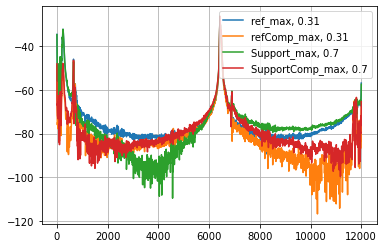

In [30]:
fig, ax = plt.subplots(1,1)
ax.plot(d, ser.dB(np.fft.ifft(ref_max)), label=f"ref_max, {conf.ref.elevation[iElevRef]:.2f}")
ax.plot(d, ser.dB(np.fft.ifft(refComp_max)), label=f"refComp_max, {conf.ref.elevation[iElevRef]:.2f}")
ax.plot(d, ser.dB(np.fft.ifft(support_max)), label=f"Support_max, {conf.sup.elevation[iElevSupportMax]}")
ax.plot(d, ser.dB(np.fft.ifft(supportComp_max)), label=f"SupportComp_max, {conf.sup.elevation[iElevSupportMax]}")
ax.legend()
ax.grid()

# Save data

In [34]:
tmp = np.zeros((conf.ref.nb_freq, 3))
tmp[:,0] = freq_reference
tmp[:,1] = np.real(ref_max)
tmp[:,2] = np.imag(ref_max)
file_ref = f"{conf.out_path}/data/WR15_S11_plaque_ref.txt"
np.savetxt(file_ref, tmp, header="GHz real imag")
print(file_ref)

/home/pleroy/DATA/CAMILL/WR15_v2/processing/wr15/data/WR15_S11_plaque_ref.txt


In [36]:
tmp = np.zeros((conf.ref.nb_freq, 3))
tmp[:,0] = freq_reference
tmp[:,1] = np.real(support_max)
tmp[:,2] = np.imag(support_max)
file_support = f"{conf.out_path}/data/WR15_S11_plaque_support.txt"
np.savetxt(file_support, tmp, header="GHz real imag")
print(file_support)

/home/pleroy/DATA/CAMILL/WR15_v2/processing/wr15/data/WR15_S11_plaque_support.txt
